In [1]:
import numpy as np
import networkx as nx
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import random

In [2]:
n = 100 # network size
N = nx.cycle_graph(n) # create a test network
M = nx.complete_graph(n)
p = 0.7 # cascade spreading probablioty
pstart = 0.95 # first spread probability
T = 200 # number of iterations
Trials = 3 # number of trials
seed = int(n/2) # node that the spread starts
threshold = 0.1 # resistence of the node to it's neighbors' excitation level

def tweak_sparse_matrix(tweaked, rows, cols, vals): #tweaked is the sparse matrix, rows,cols,vals are lists
    #returns: tweaked sparse.csr_matrix
    data = np.array(vals, dtype = np.int32)
    rows = np.array(rows)
    cols = np.array(cols)
    sparse = csr_matrix((data,(cols,rows)), shape = tweaked.shape)
    return(sparse)

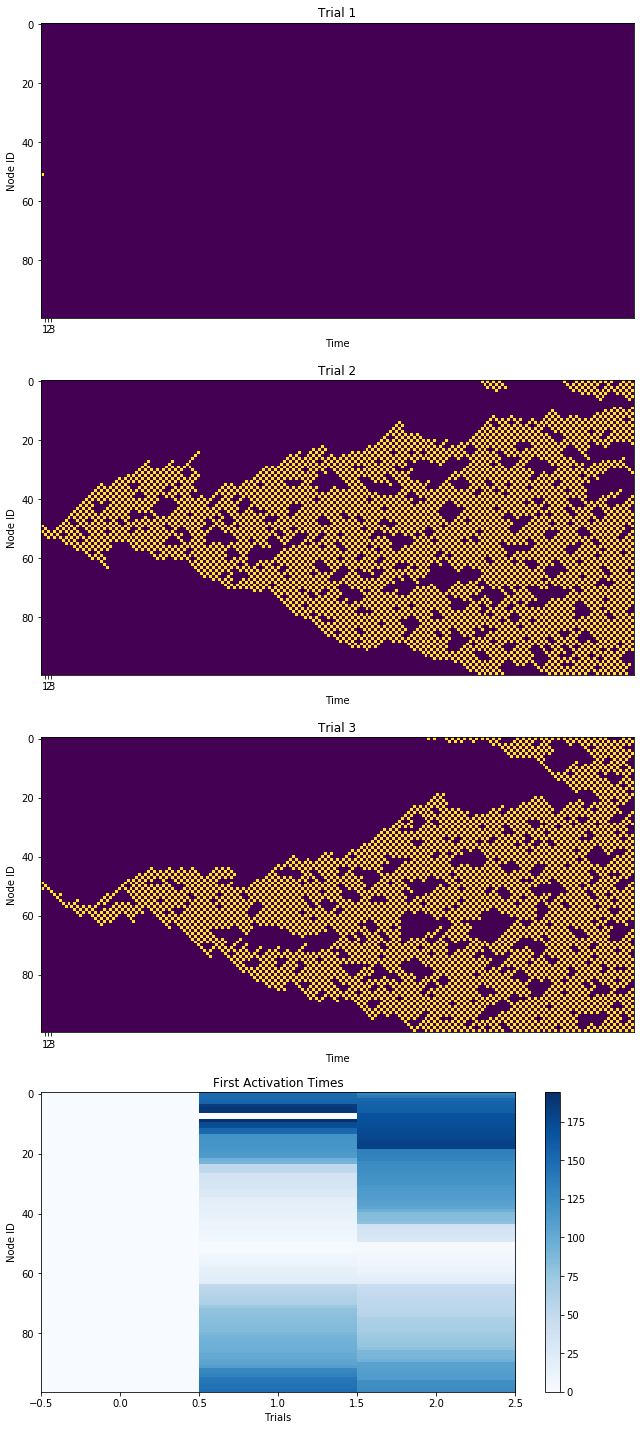

In [3]:
first_activation_times = np.zeros((n,Trials), dtype = np.int32)
fig,ax = plt.subplots(Trials+1,1, figsize = (3*Trials, 20))
for i in range(Trials):
    
    x = csr_matrix((n, T+1), dtype = int)
    initial_cluster = np.nonzero(nx.adjacency_matrix(N)[seed])[1].tolist()
    deg = len(initial_cluster)
    ps = np.array([random.uniform(0,1) for i in range(deg)])
    pstarts = np.array([1-pstart for i in range(deg)])
    vals = ps > pstarts
    rows = [0 for i in range(deg)]
    x_1 = tweak_sparse_matrix(x, rows, initial_cluster, vals.tolist())
    
    for t in range(T):
        x_old = x_1.toarray()[:,t]
        excited_nodes = np.nonzero(x_old)[0]
        
        if sum(a for a in first_activation_times[:,i] if a>0) < t*n:
            for j in excited_nodes:
                if first_activation_times[j,i] == 0:
                    first_activation_times[j,i] = t
                    
        for j in list(set([k for k in range(n)])-set(excited_nodes)): 
            ids = np.nonzero(nx.adjacency_matrix(N)[j])[1]
            rands = [random.uniform(0,1) for i in range(len(ids))]
            val = int(sum(x_old[e]*rands[y] for y,e in enumerate(ids) if x_old[e]*rands[y]>1-p) >= threshold)
            x_2 = x_1.tolil()
            x_2._set_intXint(j,t+1,val)
            x_1 = x_2.tocsr()
            
    ax[i].imshow(x_1.todense())
    ax[i].set_title('Trial %d'%(i+1))
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Node ID')
    ax[i].set_xticks([1,2,3])
    
pos = ax[Trials].imshow(first_activation_times, interpolation = 'nearest', aspect = 'auto', cmap = 'Blues')
ax[Trials].set_title('First Activation Times')
ax[Trials].set_xlabel('Trials')
ax[Trials].set_ylabel('Node ID')
fig.colorbar(pos, ax = ax[Trials])

plt.tight_layout()